# Analyze Seattle's Airbnb listing data

Project for Udacity's Data Science Nano Degree. In this notebook, I'll analyze Airbnb listing data in Seattle and try to answer business questions about this data

### Import libraries

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
listing = pd.read_csv('./data-airbnb-seattle/listings.csv')
calendar = pd.read_csv('./data-airbnb-seattle/calendar.csv')
reviews = pd.read_csv('./data-airbnb-seattle/reviews.csv')

### Question 1: Top 3 most popular neighborhoods 

To find Seattle's most popular neighborhoods on Airbnb, we can use the number of reviews as an indicator of popularity. The more reviews a neighborhood's listings has, the more popular that neighborhood is. The dataset has `neighborhood_cleansed` column to identify smaller neighborhoods and `neighborhood_group_cleansed` column that groups smaller neighborhoods into larger groups. 

In [5]:
most_popular_neighborhood_groups = listing.groupby(by='neighbourhood_group_cleansed')['number_of_reviews'].sum().reset_index()
most_popular_neighborhood_groups = most_popular_neighborhood_groups.sort_values(by='number_of_reviews', ascending=False).reset_index()

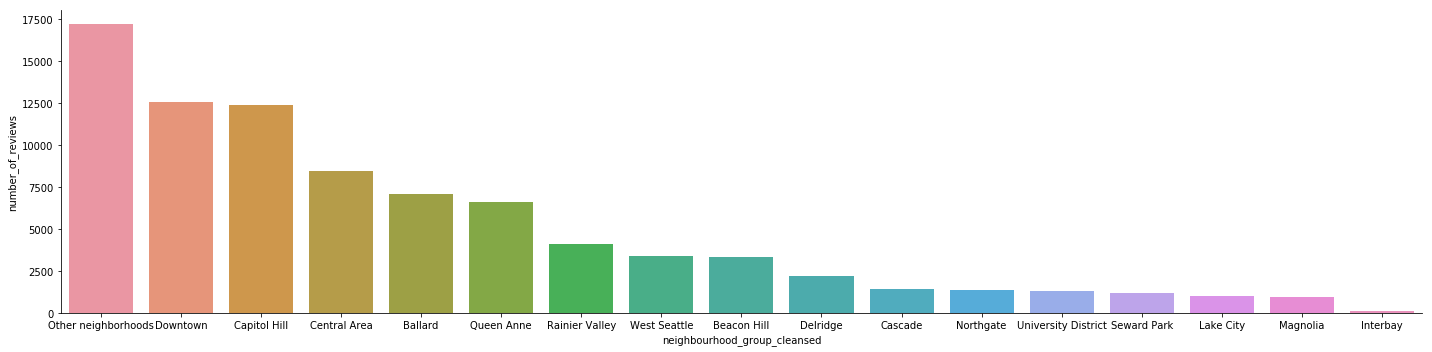

In [6]:
sns.catplot(x="neighbourhood_group_cleansed", 
            y="number_of_reviews", 
            kind="bar", 
            data=most_popular_neighborhood_groups,
            height=5, 
            aspect=4);

Top 3 groups of neighborhoods, not including "Other neighborhoods", are "Downtown", "Capital Hill", and "Central Area"

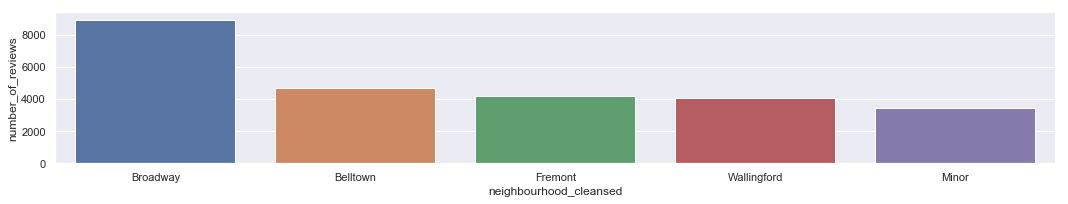

In [166]:
most_popular_neighborhoods = listing.groupby(by='neighbourhood_cleansed')['number_of_reviews'].sum().reset_index()
most_popular_neighborhoods = most_popular_neighborhoods.sort_values(by='number_of_reviews', ascending=False).reset_index()
sns.catplot(x="neighbourhood_cleansed", 
            y="number_of_reviews", 
            kind="bar", 
            data=most_popular_neighborhoods.head(5),
            height=3, 
            aspect=5);

Top 3 individual neighborhoods are "Broadway", "Belltown", and "Fremont"

### Question 2: What are price and availability trends throughout the year?

In [8]:
calendar['date']= pd.to_datetime(calendar['date'],format='%Y-%m-%d')

In [9]:
# Drop rows in 2017 so we have correct data
calendar = calendar.drop(calendar.tail(2).index)
calendar.tail()

,listing_id,date,available,price
1393563,10208623,2016-12-27,f,NaN
1393564,10208623,2016-12-28,f,NaN
1393565,10208623,2016-12-29,f,NaN
1393566,10208623,2016-12-30,f,NaN
1393567,10208623,2016-12-31,f,NaN


In [10]:
# Convert price and available columns to correct data types
calendar['price'] = calendar['price'].str.replace(',', '').str.replace('$', '').astype(float)
calendar['available'] = calendar['available'].replace({'t':True, 'f':False})

In [11]:
# Create date, month, year columns
calendar['year']= calendar['date'].dt.year
calendar['month']= calendar['date'].dt.month
calendar['day']= calendar['date'].dt.day

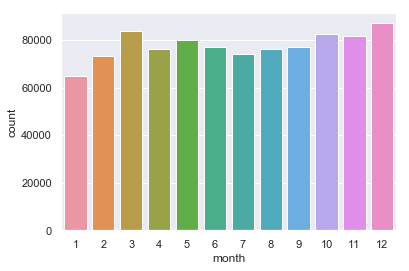

In [167]:
# See availability trend throughout the year
sns.set(style="darkgrid")
ax = sns.countplot(x="month", data=calendar[calendar['available']])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


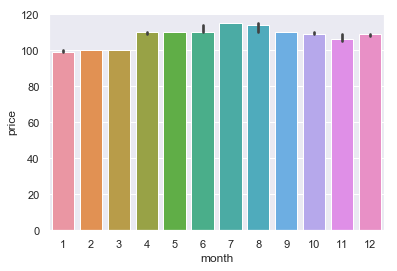

In [13]:
# See price trend throughout the year
sns.set(style="darkgrid")
ax = sns.barplot(x="month", y="price",data=calendar[calendar['available']], estimator=np.median)

In [14]:
reviews['date']= pd.to_datetime(reviews['date'],format='%Y-%m-%d')
# Create date, month, year columns
reviews['year']= reviews['date'].dt.year
reviews['month']= reviews['date'].dt.month
reviews['day']= reviews['date'].dt.day

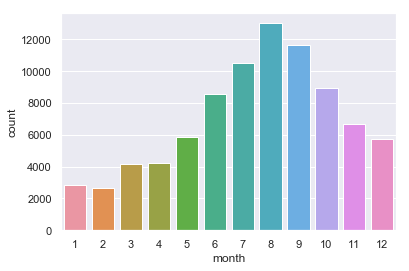

In [15]:
# See availability trend throughout the year
sns.set(style="darkgrid")
ax = sns.countplot(x="month", data=reviews)

June until October are very popular months for visitors to Seattle. The number of reviews peaks in August, totalling over 12,000.

### Question 3: Is there a correlation between number of amenities and review scores?

Travelers have diverse needs, and being able to accommodate these needs could potentially mean more bookings and happier guests. It may be interesting for us to look at number of amenities and review scores to see if there's a correlation between them

In [16]:
# Convert 'amenities' column to list type
listing['amenities'] = listing['amenities'].str.replace('"','').str.replace('{','').str.replace('}','').str.split(',')

In [17]:
# Create a column to store number of amenities each listing has
listing['num_of_amenities']=listing['amenities'].str.len()

In [18]:
# Convert price column to numeric type
listing['price'] = listing['price'].str.replace(',', '').str.replace('$', '').astype(float)

Examine the correlation among the continuous variables

In [168]:
corr = listing[['num_of_amenities','price','accommodates','bathrooms', 'bedrooms','review_scores_value']].corr(method ='pearson')

In [169]:
corr

,num_of_amenities,price,accommodates,bathrooms,bedrooms,review_scores_value
num_of_amenities,1.000000,0.184176,0.270891,0.141221,0.175227,0.081817
price,0.184176,1.000000,0.652218,0.516424,0.627720,-0.041776
accommodates,0.270891,0.652218,1.000000,0.538439,0.770974,-0.062041
bathrooms,0.141221,0.516424,0.538439,1.000000,0.610937,0.014297
bedrooms,0.175227,0.627720,0.770974,0.610937,1.000000,-0.001208
review_scores_value,0.081817,-0.041776,-0.062041,0.014297,-0.001208,1.000000


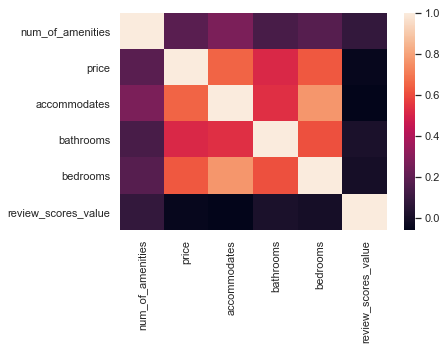

In [170]:
ax = sns.heatmap(corr)

The number of amenities a listing has doesn't seem to have a strong correlation to review score

### Question 4: Can the data about the listing predict its price?

In [23]:
col_names = ['id', 'last_scraped', 'host_name','host_since', 
        'host_is_superhost', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'bed_type',
       'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'number_of_reviews', 'first_review','last_review',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count','num_of_amenities']

In [24]:
listing_cleaned = listing[col_names]

In [25]:
# Look at missing values
for col in col_names:
    if (listing_cleaned[col].isna().sum() > 0):
        print(col, listing_cleaned[col].isna().sum())

host_name 2
host_since 2
host_is_superhost 2
host_identity_verified 2
property_type 1
bathrooms 16
bedrooms 6
security_deposit 1952
cleaning_fee 1030
first_review 627
last_review 627
review_scores_accuracy 658
review_scores_cleanliness 653
review_scores_checkin 658
review_scores_communication 651
review_scores_location 655
review_scores_value 656


In [26]:
# Convert security_deposit and cleaning_fee's NaN values to 0
listing_cleaned['security_deposit'] = listing_cleaned['security_deposit'].str.replace(',', '').str.replace('$', '').astype(float).fillna(0)
listing_cleaned['cleaning_fee'] = listing_cleaned['cleaning_fee'].str.replace(',', '').str.replace('$', '').astype(float).fillna(0)
listing_cleaned['extra_people'] = listing_cleaned['extra_people'].str.replace(',', '').str.replace('$', '').astype(float).fillna(0)
listing_cleaned['last_review'] = pd.to_datetime(listing_cleaned['last_review'],format='%Y-%m-%d')
listing_cleaned['first_review'] = pd.to_datetime(listing_cleaned['first_review'],format='%Y-%m-%d')
listing_cleaned['host_since'] = pd.to_datetime(listing_cleaned['host_since'],format='%Y-%m-%d')
listing_cleaned['host_is_superhost'] = listing_cleaned['host_is_superhost'].replace({'True':1, 'False':0})
listing_cleaned['host_identity_verified'] = listing_cleaned['host_identity_verified'].replace({'True':1, 'False':0})


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [27]:
# Convert variables with t and f values into true boolean
listing_cleaned = listing_cleaned.replace({'t':1, 'f':0})

The rest of the missing values are likely from the listings being newer and they haven't received reviews. So we can probably drop the rows from our data set without affecting the ability to predict top 10 listings

In [28]:
# Drop rows with missing values
listing_cleaned = listing_cleaned.dropna().reset_index(drop=True)
print(listing_cleaned.shape[0])

3140


In [29]:
# Calculate approximate number of days listing has been on Airbnb
listing_cleaned['listing_duration'] = listing_cleaned['last_review'] - listing_cleaned['first_review']
listing_cleaned['listing_duration'] = listing_cleaned['listing_duration']/np.timedelta64(1,'D')
# Calculate approximate number of days a host has been on Airbnb
listing_cleaned['host_duration'] = listing_cleaned['last_review'] - listing_cleaned['host_since']
listing_cleaned['host_duration'] = listing_cleaned['host_duration']/np.timedelta64(1,'D')

In [30]:
listing_cleaned[['host_since','first_review','last_review','listing_duration','host_duration']].head()

,host_since,first_review,last_review,listing_duration,host_duration
0,2011-08-11,2011-11-01,2016-01-02,1523.0,1605.0
1,2013-02-21,2013-08-19,2015-12-29,862.0,1041.0
2,2014-06-12,2014-07-30,2015-09-03,400.0,448.0
3,2011-11-29,2012-07-10,2015-10-24,1201.0,1425.0
4,2010-12-25,2015-06-11,2015-09-28,109.0,1738.0


In [32]:
feature_cols = ['host_is_superhost',
       'host_identity_verified',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'bed_type', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights',
       'number_of_reviews',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'num_of_amenities', 'listing_duration', 'host_duration']

In [33]:
# function to create dummy variables for all categorical variables (source: Udacity)
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [34]:
cat_cols = ['neighbourhood_group_cleansed', 'bed_type',
       'property_type', 'room_type', 'cancellation_policy']

In [82]:
listing_cleaned_new = create_dummy_df(listing_cleaned[feature_cols], cat_cols, dummy_na=False)

In [93]:
X = listing_cleaned_new.drop(columns='price')
y = listing_cleaned_new['price']

In [94]:
print(X.shape[0], y.shape[0])

3140 3140


In [95]:
def fit_linear_mod(y, X, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    y - column we want to predict
    X - features we're using to predict y
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    # Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    # Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [96]:
# Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(y, X, dummy_na=False)

In [97]:
# Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.6290587357234376.  The rsquared on the test data was 0.5546715056898666.


Our linear regression model explains around 63% of the variation of pricing in the training set, and 55% of variation of pricing in test set 